# Main simiulation

In [87]:
import pathlib

import matplotlib.pyplot as plt
import pedpy
from matplotlib.patches import Circle
from shapely import Polygon
import plotly.graph_objects as go

%matplotlib inline


from Py.classes.riskSimulationValues import RiskSimulationValues
from Py.animation import animate
from Py.classes.simulation_config import SimulationConfig
from Py.classes.agentGroup import AgentGroup
import polygons.environmnet as pol
from Py.simulation_manager import *

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

## Choosing the Environment

In [88]:
# Environment = pol.get_simple_3x3()
# Environment = pol.get_multi_floor_3x3()
Environment = pol.get_comparing_algorithms_pol()

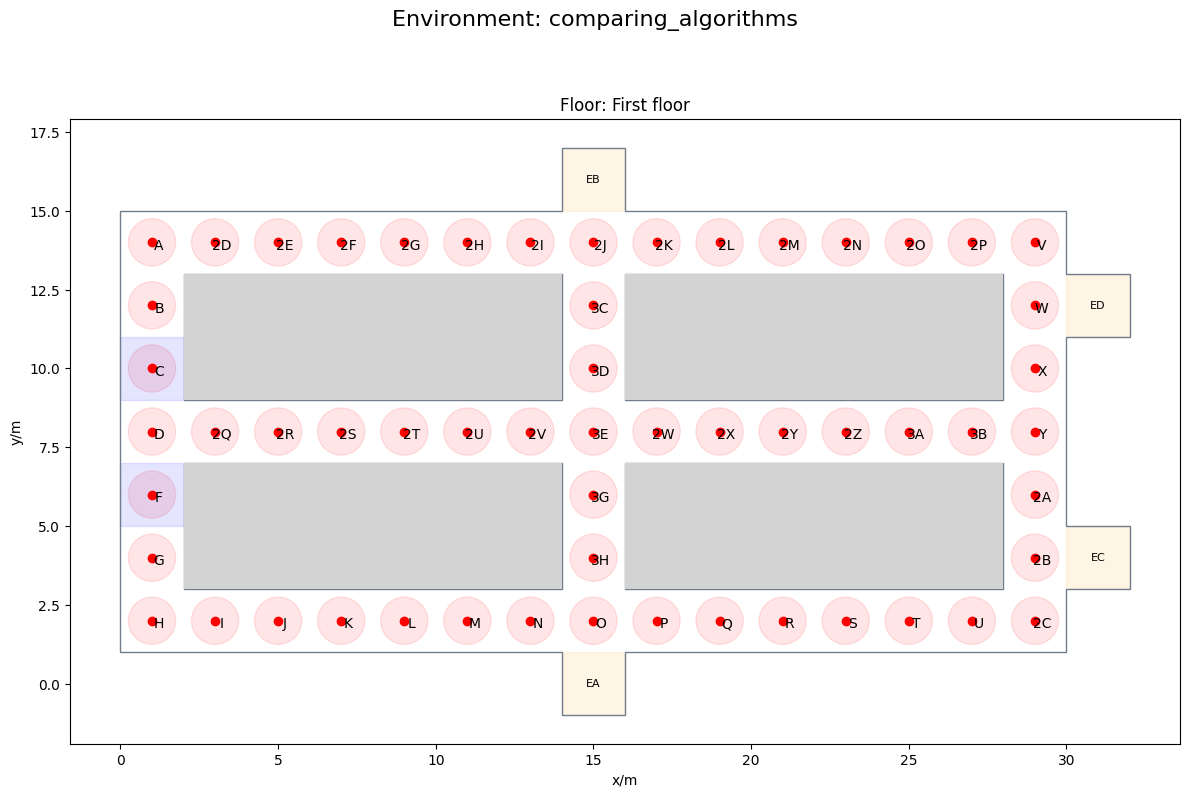

In [89]:
Environment_name = Environment.name
n_floors = len(Environment.floors)

fig, axes = plt.subplots(nrows=1, ncols=n_floors, figsize=(12, 8))
if n_floors == 1:
    axes = [axes]

fig.suptitle(f"Environment: {Environment.name}", fontsize=16)

for ax, (floor_key, floor) in zip(axes, Environment.floors.items()):
    # Set aspect ratio to equal
    ax.set_aspect("equal")

    # Plot the walkable area (using pedpy)
    pedpy.plot_walkable_area(walkable_area=floor.walkable_area, axes=ax)

    # Plot each waypoint as a red dot and annotate with its key
    for waypoint_key, (waypoint, distance) in floor.waypoints.items():
        ax.plot(waypoint[0], waypoint[1], "ro")
        ax.annotate(
            f"{waypoint_key}",
            (waypoint[0], waypoint[1]),
            textcoords="offset points",
            xytext=(5, -5),
            ha="center",
        )
        circle = Circle(
            (waypoint[0], waypoint[1]),
            distance,
            fc="red",
            ec="red",
            alpha=0.1
        )
        ax.add_patch(circle)

    # Plot each exit polygon (with orange color)
    for exit_key, exit_coords in floor.exit_polygons.items():
        # Create a polygon from the exit coordinates
        exit_poly = Polygon(exit_coords)
        x, y = exit_poly.exterior.xy
        ax.fill(x, y, alpha=0.1, color="orange")
        centroid = exit_poly.centroid
        ax.text(centroid.x, centroid.y, f"{exit_key}", ha="center", va="center", fontsize=8)

    # Plot each distribution polygon (with blue color)
    for dist_key, dist_poly in floor.distribution_polygons.items():
        x, y = dist_poly.exterior.xy
        ax.fill(x, y, alpha=0.1, color="blue")

    # Set the title of this subplot to the floor's name
    ax.set_title(f"Floor: {floor.name}")

plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
plt.show()

## Configuration of Simulation Scenarios

In [90]:
# List of algorithm/awareness modes to use for the simulation
modes = [0, 1, 2, 3]

# Global dictionary to store simulations per floor.
simulations_by_floor = {}

for floor_key, floor in Environment.floors.items():
    simulations = {}
    for mode in modes:
        trajectory_file = f"../../sqlite_data/{floor.name}_modes_{mode}.sqlite"

        simulation = jps.Simulation(
            model=jps.CollisionFreeSpeedModel(
                strength_neighbor_repulsion=2.6,     # Strength of repulsion between neighboring agents
                range_neighbor_repulsion=0.1,        # Distance at which agents begin to repel each other
                range_geometry_repulsion=0.05,       # Distance at which agents start to avoid obstacles
            ),
            geometry=floor.walkable_area.polygon,
            trajectory_writer=jps.SqliteTrajectoryWriter(
                output_file=pathlib.Path(trajectory_file)
            ),
        )
        simulations[mode] = simulation
    simulations_by_floor[floor_key] = simulations

## Journey configuration

In [91]:
# In journey_configuration.py

## Allocate Agents

In [92]:
total_agents = 5

positions_by_floor = {}

for floor_key, floor in Environment.floors.items():
    positions = {}
    for source in floor.sources:
        positions[source] = jps.distribute_by_number(
            polygon=floor.distribution_polygons[source],
            number_of_agents=total_agents,
            distance_to_agents=0.4,
            distance_to_polygon=0.5,
            seed=1234,
        )
    positions_by_floor[floor_key] = positions

## Launching the Simulation

In [93]:
G = Environment.graph

# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = True

# Important parameters
risk_threshold = 0.5
gamma = 0.4
stairs_max_speed = 0.6
normal_max_speed = 1.2

# set agent groups
modes_names = ["Low_awareness_efficient_paths", "High_awareness_efficient_paths", "Low_awareness_centrality_path", "High_awareness_centrality_path"]
awareness_levels_per_group = [0, 1, 0, 1]
algorithm_per_group = [0, 0, 1, 1]

In [94]:
every_nth_frame_simulation = 4  # Interval of iterations for frames
                                # 4 is the simulation writers default

every_nth_frame_animation = 50  # Interval of frames for risk updates
                                # 50 is the animations default

# Simulation parameters
riskSimulationValues = RiskSimulationValues(3000, 0.05, risk_threshold)

# Establish a connection to the appropriate SQLite database
default_connection_file = f"../../sqlite_data/default_{Environment_name}_risks.db" # default risk evolution file
new_connection_file = f"../../sqlite_data/{Environment_name}_risks.db" # random risk evolution file
if use_random_risk_layout:
    connection_file = default_connection_file  # Use new database if random risk layout is enabled
else:
    connection_file = default_connection_file  # Use default database otherwise

connection = sqlite3.connect(connection_file)
try:
    if use_random_risk_layout:
        # Create or reset the risk table if random risk layout is enabled
        create_risk_table(connection)

        # Simulate risk propagation and store results in the database
        simulate_risk(riskSimulationValues, every_nth_frame_animation, G, Environment.floors[0].exit_polygons.keys(), connection) # animation not every frame is shown in the animation
    # get first frame risk table
    risk_first_frame= get_risk_levels_by_frame(connection, 0)
finally:
    # Ensure the database connection is closed after operations
    connection.close()

In [95]:
floor_simulation_data = {}

# Dictionary to store data of agents that reached stairs.
# The key is the agent's ID and the value is a dict with 'position' and 'frame'.
stairs_agents_data = {}

# Get the list of floor keys sorted from highest to lowest.
# (Assuming floor keys are numeric, with 0 being the lowest floor)
sorted_floor_keys = sorted(Environment.floors.keys(), reverse=True)

for idx, floor_key in enumerate(sorted_floor_keys):
    floor = Environment.floors[floor_key]
    env_name = floor.name  # e.g., "First Floor"
    simulations = simulations_by_floor[floor_key]

    trajectory_files = {}
    agent_groups_per_mode = {}
    agent_area_files = {}

     #if idx > 0:
     #   prev_floor_key = sorted_floor_keys[idx - 1]
     #   for mode in modes:
     #       stairs_agents = get_stairs_agents(prev_floor_key, mode, floor_simulation_data, G)
     #       stairs_agents_data.update(stairs_agents)

    # Loop over each simulation mode for the current floor.
    for mode, simulation in simulations.items():
        # In cases with low awareness the floors graph is used, whereas in high awareness cases the global graph is used
        if mode in [0,2]:
            G = Environment.floors[floor_key].graph
        else:
            G = Environment.graph

        # Define the output file path for storing the agent area data.
        agent_area_files[mode] = f"../../sqlite_data/agent_area_{env_name}_mode_{mode}.db"
        agent_area_connection = sqlite3.connect(agent_area_files[mode])
        create_agent_area_table(agent_area_connection)

        # Add exit stages to the simulation for each exit polygon.
        exit_ids = {}
        for node, exit_polygon in floor.exit_polygons.items():
            exit_ids[node] = simulation.add_exit_stage(exit_polygon)

        # Initialize a dictionary to store waypoint IDs.
        waypoints_ids = {}
        for node, (waypoint, distance) in floor.waypoints.items():
            waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

        # Build agent groups for each source.
        agent_groups = dict()
        for source in floor.sources:
            # Create a new AgentGroup instance.
            agent_group_aux = AgentGroup(
                None, None, None, None,
                algorithm_per_group[mode],
                awareness_levels_per_group[mode],
                floor_key
            )

            print("mode: ",mode)
            print("awareness: ",algorithm_per_group[mode])
            print("algorithm: ",awareness_levels_per_group[mode])

            # Compute an alternative path for the source.
            path = compute_alternative_path(
                floor.exit_polygons.keys(), agent_group_aux, G, source,
                risk_per_node=risk_first_frame, gamma=gamma
            )

            # Set up the journey for the simulation.
            journeys_ids = set_journeys(simulation, source, [path], waypoints_ids, exit_ids)
            # Get the journey ID and best path for this source.
            journey_id, best_path_source = journeys_ids[source][0]
            next_node = best_path_source[1]  # Next node on the best path.
            first_waypoint_id = waypoints_ids[next_node]

            # Create agents in the simulation using precomputed positions.
            agents = set_agents_in_simulation(
                simulation, positions_by_floor[floor_key][source], journey_id, first_waypoint_id, normal_max_speed
            )

            # Update the agent group with the computed path and agents.
            agent_group_aux.path = path
            agent_group_aux.current_nodes = {agent: path[0] for agent in agents}
            agent_group_aux.agents = agents

            agent_groups[source] = agent_group_aux

        # Build the simulation configuration for this floor and mode.
        simulation_config = SimulationConfig(
            simulation,
            Environment,
            every_nth_frame_simulation,
            every_nth_frame_animation,
            waypoints_ids,
            exit_ids,
            gamma,
            normal_max_speed,
            stairs_max_speed
        )

        # Create a connection for risk levels.
        connection = sqlite3.connect(connection_file)
        # Run the agent simulation, updating paths based on risk levels.
        run_agent_simulation(
            simulation_config,
            agent_groups,
            G,
            connection,
            agent_area_connection,
            risk_threshold=risk_threshold
        )

        connection.close()
        agent_area_connection.close()

        # Generate and store the trajectory file path.
        trajectory_file = f"../../sqlite_data/{env_name}_modes_{mode}.sqlite"
        trajectory_files[mode] = trajectory_file
        agent_groups_per_mode[mode] = agent_groups

    # Store all simulation data for this floor in the global dictionary.
    floor_simulation_data[floor_key] = {
        'trajectory_files': trajectory_files,
        'agent_groups_per_mode': agent_groups_per_mode,
        'agent_area_files': agent_area_files,
    }

mode:  0
awareness:  0
algorithm:  0
mode:  0
awareness:  0
algorithm:  0
hola
mode:  1
awareness:  0
algorithm:  1
mode:  1
awareness:  0
algorithm:  1
hola
mode:  2
awareness:  1
algorithm:  0
mode:  2
awareness:  1
algorithm:  0
hola
mode:  3
awareness:  1
algorithm:  1
mode:  3
awareness:  1
algorithm:  1
hola


In [96]:
with sqlite3.connect(connection_file) as connection:
    risks_by_floor = get_risks_grouped_by_frame_and_floor(connection)

In [97]:
with sqlite3.connect(floor_simulation_data[0]["agent_area_files"][1]) as connection:
    all_agent_areas = read_agent_area_data_by_frame(connection,500)
    print(all_agent_areas)

   frame  agent_id area  risk
0    500       211   EB   0.0
1    500       212   EB   0.0
2    500       213   EB   0.0
3    500       214   EB   0.0
4    500       215   EB   0.0
5    500       216   2I   0.0
6    500       217   EB   0.0
7    500       218   2I   0.0
8    500       219   2I   0.0
9    500       220   EB   0.0


In [98]:

get_stairs_agents(0,0,floor_simulation_data, G)

{}

## Visualizing Agent Pathways

In [99]:
agent_trajectories_by_floor = {}

for floor_key, floor in Environment.floors.items():
    agent_trajectories = {}

    for mode in modes:
        trajectory_file = floor_simulation_data[floor_key]["trajectory_files"][mode]

        agent_trajectories[mode], walkable_area = read_sqlite_file(trajectory_file)

        animate(
            agent_trajectories[mode],
            walkable_area,
            title_note=f"Floor: {floor_key}, Mode: {modes_names[mode]}",
            risk_per_frame=risks_by_floor[floor_key],
            specific_areas=floor.specific_areas
        ).show()

    agent_trajectories_by_floor[floor_key] = agent_trajectories

## Analysus if the results

In [100]:
# show the hazzards of a specific frame
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks_frame_550 = get_risk_levels_by_frame(connection, 400)

risky_areas = []
for area, risk in all_risks_frame_550.items():
    if risk > 0.0:
        risky_areas.append((area, risk))

# Retrieve the boundary coordinates of the complete_area polygon
minx, miny, maxx, maxy = complete_area.bounds

# Create a figure with subplots arranged in two rows and two columns
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 16),
)

# Flatten the axes array to simplify iteration
axes = axes.flatten()

# Define a list of colors to differentiate agent groups in the plots
colors = ["red", "blue"]

# Iterate over each subplot axis and its corresponding mode
for ax, mode in zip(axes, agent_groups_per_mode):
    # Extract trajectory data for the current mode
    trajectories = agent_trajectories[mode].data

    # Initialize a list to hold groups of agents for the current mode
    list_of_groups = []

    # Populate the list with agent groups from each source
    for source in sources:
        list_of_groups.append(agent_groups_per_mode[mode][source].agents)

    # Iterate over each group of agents
    for ig, group in enumerate(list_of_groups):
        # Create a TrajectoryData object for the current group
        traj = pedpy.TrajectoryData(
            trajectories[trajectories["id"].isin(group)],
            frame_rate=agent_trajectories[mode].frame_rate,
        )

        # Plot the trajectories of the current group on the current axis
        pedpy.plot_trajectories(
            traj=traj,
            walkable_area=walkable_area,
            axes=ax,
            traj_color=colors[ig],
            traj_width=0.5,
            traj_start_marker=".",
        )

    # Set the title of the subplot to indicate the current mode
    ax.set_title(f"Mode: {modes_names[mode]}")

    # Set the x and y axis limits based on the complete_area boundaries
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Ensure the aspect ratio is equal to maintain the scale of the plot
    ax.set_aspect('equal', adjustable='box')

    # Overlay exit polygons on the plot
    for name, exit_polygon in exit_polygons.items():
        # Extract the x and y coordinates of the polygon's exterior
        x, y = Polygon(exit_polygon).exterior.xy

        # Fill the polygon area with a semi-transparent red color
        ax.fill(x, y, alpha=0.1, color="red")

        # Outline the polygon with a white border
        ax.plot(x, y, color="white")

        # Calculate the centroid of the polygon
        centroid = Polygon(exit_polygon).centroid

        # Place the name of the exit at the centroid position
        ax.text(
            centroid.x, centroid.y, name, ha="center", va="center", fontsize=10
        )


    for area, risk_value in risky_areas:
        if risk_value > 0.0:
            x, y = specific_areas[area].exterior.xy
            if risk_value < risk_threshold:
                ax.fill(x, y, alpha=0.5, color="pink")
            else:
                ax.fill(x, y, alpha=0.5, color="purple")


# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Set the final size of the figure if needed
fig.set_size_inches((10, 12))

# Display the figure with all subplots
plt.show()


NameError: name 'complete_area' is not defined

## Calculate profiles

### Step 1: Compute individual speeds and Voronoi cells for each mode

In [ ]:
individual_speed_per_mode = dict()
individual_voronoi_cells_per_mode = dict()

# Loop over each mode in the list of modes
for mode in modes:
    # Compute individual speed for the current mode
    individual_speed = pedpy.compute_individual_speed(
        traj_data=agent_trajectories[mode],
        frame_step=5,
        speed_calculation=pedpy.SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    # Compute individual Voronoi polygons for the current mode
    individual_voronoi_cells = pedpy.compute_individual_voronoi_polygons(
        traj_data=agent_trajectories[mode],
        walkable_area=walkable_area,
        cut_off=pedpy.Cutoff(radius=0.8, quad_segments=3),
    )

    # Save the computed data into dictionaries keyed by mode
    individual_speed_per_mode[mode] = individual_speed
    individual_voronoi_cells_per_mode[mode] = individual_voronoi_cells

### Step 2: Compute density and speed profiles for each mode

In [ ]:
# Define the frame range for profile computation
min_frame_profiles = 600
max_frame_profiles = 700

# Initialize dictionaries to store density and speed profiles per mode
density_profiles_per_mode = dict()
speed_profiles_per_mode = dict()

# Loop over each mode to calculate the profiles
for mode in modes:
    # Filter the Voronoi data for frames within the desired range
    voronoi_filtered = individual_voronoi_cells_per_mode[mode][
        individual_voronoi_cells_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Filter the speed data for frames within the desired range
    speed_filtered = individual_speed_per_mode[mode][
        individual_speed_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Merge the filtered Voronoi and speed data on 'id' and 'frame'
    merged_data = pd.merge(
        voronoi_filtered,
        speed_filtered,
        on=["id", "frame"],
    )

    # Compute density and speed profiles using the merged data
    density_profiles, speed_profiles = pedpy.compute_profiles(
        individual_voronoi_speed_data=merged_data,
        walkable_area=walkable_area.polygon,
        grid_size=0.25,
        speed_method=pedpy.SpeedMethod.ARITHMETIC,
    )

    # Save the computed profiles in the corresponding dictionaries
    density_profiles_per_mode[mode] = density_profiles
    speed_profiles_per_mode[mode] = speed_profiles

### Step 3: Plot profiles with one row per mode and two columns per row
<div style="margin-left: 60px;"><h4>(first column: density, second column: speed)</h4></div>


In [ ]:
num_modes = len(modes)
fig, axes = plt.subplots(nrows=num_modes, ncols=2, figsize=(12, 4 * num_modes))

for idx, mode in enumerate(modes):
    # Seleccionamos el eje para densidad (columna 0) y para velocidad (columna 1)
    ax_density = axes[idx, 0]
    ax_speed = axes[idx, 1]

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=density_profiles_per_mode[mode],
        axes=ax_density,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=10,
        title=f"Density - {modes_names[mode]}",
    )

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=speed_profiles_per_mode[mode],
        axes=ax_speed,
        label="v / m/s",
        vmin=0,
        vmax=2,
        title=f"Speed - {modes_names[mode]}",
    )

fig.tight_layout(pad=2)
plt.show()

## Evacuation Times vs Mode

In [ ]:
evac_times = []
for mode, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate # time equals frame / frame rate
    evac_times.append(t_evac)

for mode in modes:
    print(f"Mode: {modes_names[mode]}, time: {evac_times[mode]:2f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

## Risk vs Mode

In [ ]:
avg_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            avg_risk[mode] = get_average_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, average risk: {avg_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(avg_risk.values()),
        name="Average Risks"
    )
)

fig.update_layout(
    title="Average Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
risk_sum = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            risk_sum[mode] = calculate_average_agent_combined_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, total risk: {risk_sum[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(risk_sum.values()),
        name="Total Risks"
    )
)

fig.update_layout(
    title="Total Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()

In [ ]:
highest_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            highest_risk[mode] = get_max_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, highest risk: {highest_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=list(modes_names),
        y=list(highest_risk.values()),
        name="Highest Risks"
    )
)

fig.update_layout(
    title="Highest Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks"
)

fig.show()